In [1]:
!pip install -r requirements.txt


  Using cached contourpy-1.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-11.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached ruptures-1.1.9-cp312-cp312-macosx_14_0_arm64.whl
  Using cached scikit_learn-1.6.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ruptures as rpt
from datetime import date
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels import api as sm


# Data Cleaning and first analysis

This section focuses on understanding and preparing user interaction data for analysis. The steps taken include:

- **Initial Data Cleaning**:  
  - Removed unnecessary columns (e.g., `offer_id`)
  - Converted `action_datetime` to proper datetime format  
  - Calculated the number of days since each user's first recorded event

- **Level Progression Analysis**:  
  - Isolated "Reach Level" events and extracted level numbers  
  - Sorted events by user and timestamp to trace progression  
  - Defined expected level sequence to validate user paths

- **Validation Checks**:  
  - Flagged users whose first level event occurred *before* their install date  
  - Detected users who skipped one or more levels  
  - Identified users with multiple install events

- **Final Filtering**:  
  - Combined all invalid user IDs into a single set  
  - Removed these users from the dataset to ensure data quality


In [3]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame by:
    - Dropping the 'offer_id' column
    - Ensuring 'action_datetime' is in datetime format
    - Calculating the number of days since each user's first event
    
    Args:
        df (pd.DataFrame): Raw input DataFrame.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """

    df = df.drop(columns=['offer_id'])
    df['action_datetime'] = pd.to_datetime(df['action_datetime'])
    first_event = df.groupby('user_id')['action_datetime'].transform('min')
    df['days_from_first_event'] = (df['action_datetime'] - first_event).dt.days
    return df

# Load data
df = pd.read_csv("actions.csv", parse_dates=['action_datetime'])

# Clean data
df_clean = clean_data(df.copy())

# Preview cleaned data
df_clean.head()


,action_id,offer_start_id,user_id,action_type,event_name,action_value,action_currency,action_datetime,days_from_first_event
0,48744666,52843058,81f093d02041832ccb0987b3005b6567b5021eaefd7bee...,install,install,NaN,NaN,2000-04-01 09:07:15,0
1,48744655,52843074,de1b52924b9433da2dbc4a2663a3ec73b69eef7ce4d5a0...,install,install,NaN,NaN,2000-04-01 09:07:34,0
2,48746381,52843417,86620306977662b3aa16e0ef6c6609e288267fc4fcd85d...,install,install,NaN,NaN,2000-04-01 09:10:21,0
3,48746950,52843427,8d41a28ad02b189a3636f8914cfc3dc4152ba4ebdce7fc...,install,install,NaN,NaN,2000-04-01 09:11:01,0
4,48744741,52843058,81f093d02041832ccb0987b3005b6567b5021eaefd7bee...,progress,Reach Level 2,NaN,NaN,2000-04-01 09:11:21,0


In [4]:
print(
    f"Event data starts from {df_clean['action_datetime'].min()} "
    f"and ends at {df_clean['action_datetime'].max()}"
)



Event data starts from 2000-04-01 09:07:15 and ends at 2000-06-30 23:59:56


In [5]:
df_clean['event_name'].value_counts()

event_name
App Launch         557071
__iap__             34032
install             28151
Reach Level 2       21809
Reach Level 4       14079
Reach Level 7       10769
Reach Level 12       8556
Reach Level 18       7873
Reach Level 35       6000
Reach Level 50       4687
Reach Level 80       3099
Reach Level 100      2651
Reach Level 135      2066
Reach Level 175      1317
Reach Level 250       436
Reach Level 300       118
Reach Level 350        52
Reach Level 400        27
Reach Level 450        14
Reach Level 500         9
Name: count, dtype: int64

User rewards:

Reach Level 35 in 10 days $10

Reach Level 100 in 20 days $20

Reach Level 175 in 50 days $40


Familiarising myself with customer journey

In [6]:
df_clean[df_clean['event_name'] == 'Reach Level 500'].head()

,action_id,offer_start_id,user_id,action_type,event_name,action_value,action_currency,action_datetime,days_from_first_event
568514,222470009,70942841,0e69b232ffb6f9851c80064f248598050b7a47c273ed5a...,progress,Reach Level 500,NaN,NaN,2000-06-18 21:20:56,14
581214,226916671,71396336,8fe54ac4ba806be52ad6827295a4f40a29d0c409162365...,progress,Reach Level 500,NaN,NaN,2000-06-19 17:16:18,14
607720,238315716,60555395,981a7671ff6f4a3bc4ebd231bccc67ed5a2b84d9042e0a...,progress,Reach Level 500,NaN,NaN,2000-06-21 18:10:21,50
608202,238528846,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,progress,Reach Level 500,NaN,NaN,2000-06-21 18:54:04,17
639806,255533947,71011743,cc23bc8a8dbc94f5ecf17fcefcbc78ba214c9085df8928...,progress,Reach Level 500,NaN,NaN,2000-06-24 17:05:55,20


In [7]:
df_clean[df_clean['user_id'] == '0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae39a3d3ed5ab659aac7e']

,action_id,offer_start_id,user_id,action_type,event_name,action_value,action_currency,action_datetime,days_from_first_event
383508,160566750,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-03 22:47:03,0
383509,160566442,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,install,NaN,NaN,2000-06-03 22:47:05,0
383593,160572663,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,progress,Reach Level 2,NaN,NaN,2000-06-03 22:54:28,0
383981,160662989,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-03 23:32:09,0
384106,160685893,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,progress,Reach Level 4,NaN,NaN,2000-06-03 23:42:07,0
...,...,...,...,...,...,...,...,...,...
617384,242811419,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-22 13:39:58,18
617529,242886028,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-22 14:00:39,18
622716,245403573,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-22 23:26:55,19
622749,245416321,71005795,0508626ad2779cd5d29a0cbaaa0b332a628042a3b04ae3...,install,App Launch,NaN,NaN,2000-06-22 23:29:47,19


Assumptions:

* Users must follow strict sequence of milestones. They cant skip levels. 
* Each user must have only one offer flow.
* install should be before any level reached

In [8]:
# --- Extract "Reach Level" events ---
level_df = df_clean[df_clean['event_name'].str.startswith('Reach Level')].copy()
level_df['level_num'] = level_df['event_name'].str.extract(r'(\d+)').astype(int)
level_df['action_datetime'] = pd.to_datetime(level_df['action_datetime'])

# Sort by user and event timestamp
level_df = level_df.sort_values(['user_id', 'action_datetime'])

# List of expected levels
expected_levels = sorted(level_df['level_num'].unique())

# --- Get the first level reach time per user ---
first_level_time = (
    level_df.groupby('user_id')['action_datetime']
    .min()
    .reset_index()
    .rename(columns={'action_datetime': 'first_level_datetime'})
)

# --- Get install datetime per user ---
install_df = df_clean[
    (df_clean['action_type'] == 'install') & (df_clean['event_name'] == 'install')
][['user_id', 'action_datetime']].copy()

install_df.rename(columns={'action_datetime': 'install_datetime'}, inplace=True)
install_df['install_datetime'] = pd.to_datetime(install_df['install_datetime'])

# --- Merge to compare install vs. first level reach time ---
timing_check = pd.merge(install_df, first_level_time, on='user_id', how='inner')

# Users whose install time is after their first level event
invalid_timing_users = timing_check[
    timing_check['install_datetime'] > timing_check['first_level_datetime']
]['user_id']

# --- Check for skipped levels per user ---
user_levels = (
    level_df.groupby('user_id')['level_num']
    .apply(list)
    .reset_index()
)

def find_missing_levels(observed: list, expected: list) -> list:
    """Return expected levels up to the max observed level that are missing."""
    observed_set = set(observed)
    expected_subset = [lvl for lvl in expected if lvl <= max(observed)]
    return sorted(set(expected_subset) - observed_set)

user_levels['missing_levels'] = user_levels['level_num'].apply(
    lambda x: find_missing_levels(x, expected_levels)
)

skipped_users = user_levels[
    user_levels['missing_levels'].apply(len) > 0
]['user_id']

# --- Combine users with skipped levels or invalid event timing ---
invalid_users = set(skipped_users) | set(invalid_timing_users)



In [9]:
# --- Identify users with multiple install events ---
multiple_installs = (
    df_clean[
        (df_clean['action_type'] == 'install') &
        (df_clean['event_name'] == 'install')
    ]
    .groupby('user_id')
    .size()
    .reset_index(name='install_count')
)

# Keep only users with more than one install
multiple_installs_users = multiple_installs[
    multiple_installs['install_count'] > 1
]['user_id']

# --- Update invalid users to include users with multiple installs ---
invalid_users |= set(multiple_installs_users)

# --- Filter out invalid users from the dataset ---
df_clean = df_clean[~df_clean['user_id'].isin(invalid_users)].copy()


# EDA

The goal of this EDA is to understand user behavior across their lifecycle by analyzing:

* Daily installation trends
* Progression through key game levels
* Conversion rates to important milestones
* Time-based qualification for rewards

In [10]:
# Extract unique "Reach Level" events from the cleaned DataFrame
level_events = (
    df_clean.loc[
        df_clean['event_name'].str.startswith('Reach Level', na=False), 'event_name'
    ]
    .dropna()
    .unique()
    .tolist()
)


In [11]:
# Step 1: Create base EDA table with first event time and install time
eda_df = (
    df_clean.groupby('user_id')
    .agg(first_event_datetime=('action_datetime', 'min'))
    .reset_index()
)

# Extract install timestamps
installs = (
    df_clean.loc[
        (df_clean['action_type'] == 'install') & (df_clean['event_name'] == 'install'),
        ['user_id', 'action_datetime']
    ]
    .rename(columns={'action_datetime': 'install_datetime'})
)

# Merge install time into base EDA table
eda_df = eda_df.merge(installs, on='user_id', how='left')

# Calculate number of days from install to first event
eda_df['days_from_install'] = (
    pd.to_datetime(eda_df['install_datetime']) - pd.to_datetime(eda_df['first_event_datetime'])
).dt.days

# Step 2: Identify and sort all level reach events
level_events = df_clean[
    df_clean['event_name'].str.startswith('Reach Level', na=False)
]['event_name'].unique().tolist()

level_events = sorted(
    level_events,
    key=lambda x: int(re.search(r'\d+', x).group())
)

# Step 3: Iterate through level events to extract timing and spend info
for level in level_events:
    # First time each user reached the level
    level_reach = (
        df_clean[df_clean['event_name'] == level]
        .sort_values('action_datetime')
        .drop_duplicates('user_id')
        [['user_id', 'action_datetime']]
        .rename(columns={'action_datetime': f'{level}_datetime'})
    )

    # Merge level reach time
    eda_df = eda_df.merge(level_reach, on='user_id', how='left')

    # Days from install to reaching this level
    eda_df[f'days_to_{level.lower().replace(" ", "_")}'] = (
        pd.to_datetime(eda_df[f'{level}_datetime']) - pd.to_datetime(eda_df['install_datetime'])
    ).dt.days

    # Filter and prepare purchase events
    purchases = df_clean[df_clean['action_type'] == 'purchase'].copy()
    purchases['action_datetime'] = pd.to_datetime(purchases['action_datetime'])

    # Merge level reach time into purchase data
    level_reach_time = level_reach.rename(columns={f'{level}_datetime': 'level_reach_time'})
    purchases = purchases.merge(level_reach_time, on='user_id', how='left')

    # Keep only purchases made before or at the level reach time
    purchases = purchases[
        (purchases['level_reach_time'].notna()) &
        (purchases['action_datetime'] <= purchases['level_reach_time'])
    ]

    # Sum purchases before reaching the level
    spend = (
        purchases.groupby('user_id')['action_value']
        .sum()
        .reset_index()
        .rename(columns={'action_value': f'purchase_until_{level.lower().replace(" ", "_")}'})
    )

    # Merge spend into EDA table
    eda_df = eda_df.merge(spend, on='user_id', how='left')

    # Drop intermediate datetime column if not needed
    eda_df.drop(columns=[f'{level}_datetime'], inplace=True)

# Add install date column
eda_df['install_date'] = pd.to_datetime(eda_df['install_datetime']).dt.date

# Remove rows with missing install datetime
eda_df = eda_df.dropna(subset=['install_datetime'])

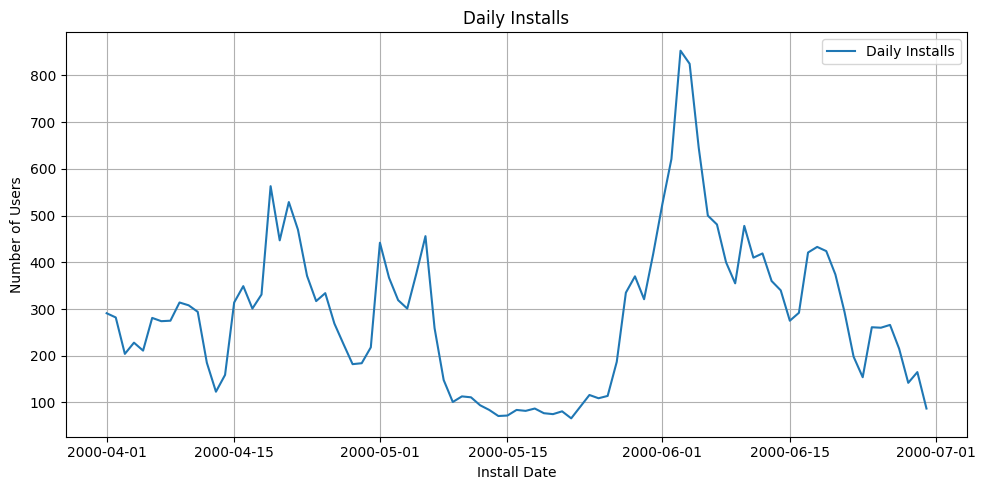

In [12]:
# Group and prepare the data
daily_installs = eda_df.groupby('install_date').count()['user_id']

# Plot using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(daily_installs.index, daily_installs.values, label='Daily Installs')

plt.title('Daily Installs')
plt.xlabel('Install Date')
plt.ylabel('Number of Users')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Define key game levels of interest for deeper analysis
key_levels = [2, 7, 35, 100, 175]

In [14]:
def compute_level_metric_by_install(df, metric_col_template, key_levels, agg_func='mean'):
    lines = []

    for level in key_levels:
        col = metric_col_template.format(level)
        if col in df.columns:
            df_level = df[~df[col].isna()].copy()
            df_level[col] = df_level[col].fillna(0)

            agg = (
                df_level.groupby('install_date')[col]
                .agg(agg_func)
                .reset_index(name='value')
            )
            agg['level'] = level
            lines.append(agg)

    result_df = pd.concat(lines, ignore_index=True)
    return result_df.pivot(index='install_date', columns='level', values='value').fillna(0)


def plot_level_lines(pivot_df, key_levels, title, ylabel):
    plt.figure(figsize=(10, 5))
    for level in key_levels:
        if level in pivot_df.columns:
            plt.plot(pivot_df.index, pivot_df[level], label=f'Level {level}')

    plt.title(title)
    plt.xlabel('Install Date')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(title='Level')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


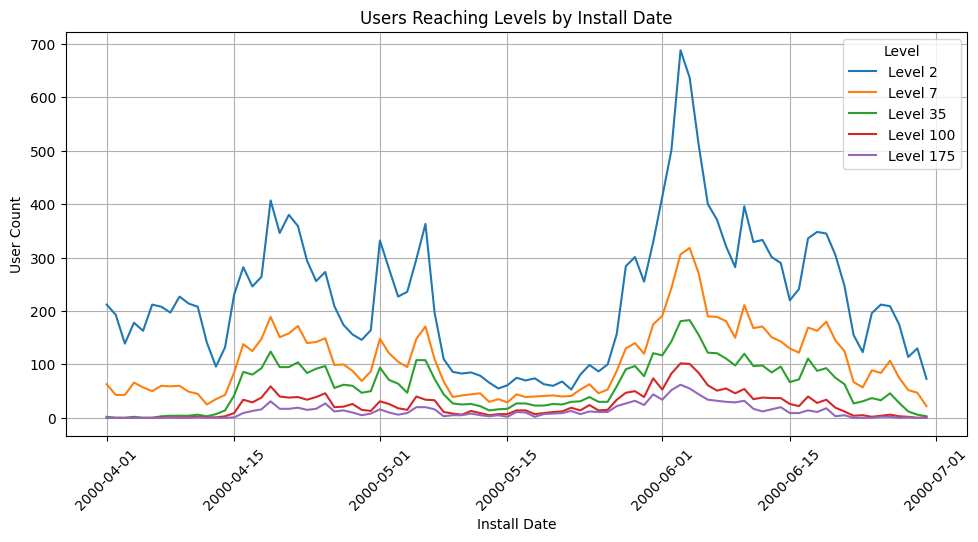

In [15]:
user_counts = compute_level_metric_by_install(
    df=eda_df.assign(dummy=1),  # workaround: 'size' requires a column to count
    metric_col_template='days_to_reach_level_{}',
    key_levels=key_levels,
    agg_func='size'
)


plot_level_lines(user_counts, key_levels, 'Users Reaching Levels by Install Date', 'User Count')

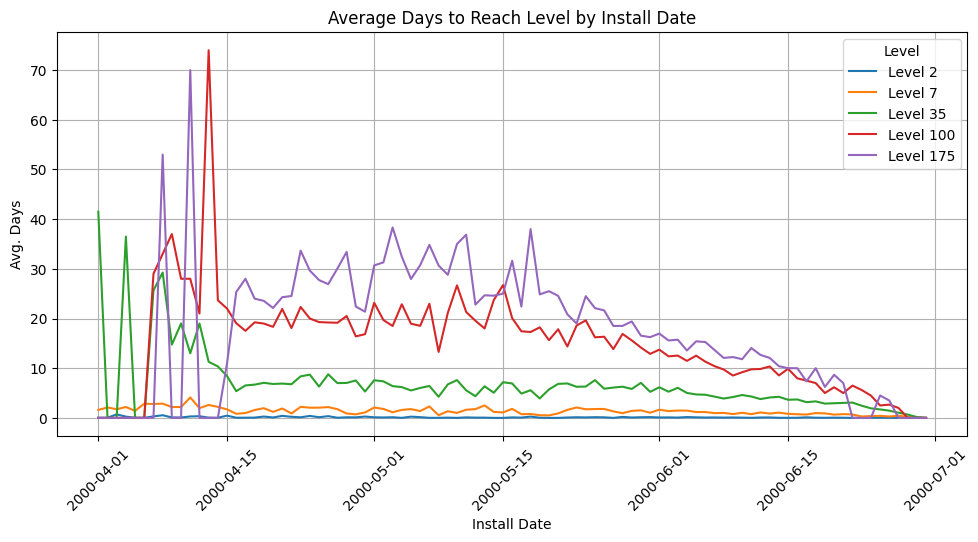

In [16]:
avg_days = compute_level_metric_by_install(
    df=eda_df,
    metric_col_template='days_to_reach_level_{}',
    key_levels=key_levels,
    agg_func='mean'
)

plot_level_lines(avg_days, key_levels, 'Average Days to Reach Level by Install Date', 'Avg. Days')

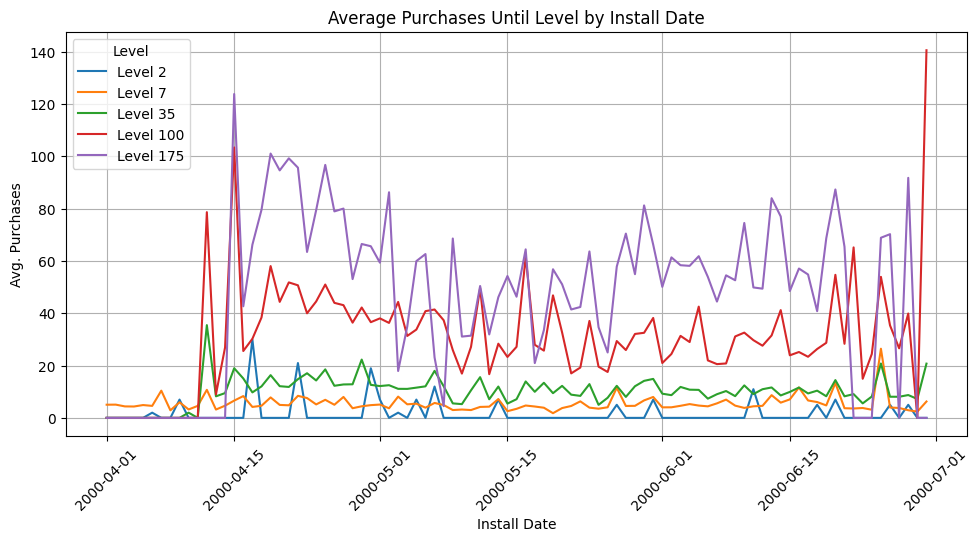

In [17]:
avg_purchases = compute_level_metric_by_install(
    df=eda_df,
    metric_col_template='purchase_until_reach_level_{}',
    key_levels=key_levels,
    agg_func='mean'
)

plot_level_lines(avg_purchases, key_levels, 'Average Purchases Until Level by Install Date', 'Avg. Purchases')

Based on the daily installs, user level progression by install date, and cumulative average purchases by level, we observe distinct patterns in user behavior over time. These trends indicate the presence of different user cohorts, likely driven by changes in acquisition strategy, game updates, or reward mechanics. Therefore, I will identify key split dates and analyze each cohort separately to better understand performance and forecast future behavior.

Index([2000-04-16, 2000-05-06, 2000-05-26, 2000-06-20], dtype='object', name='install_date')

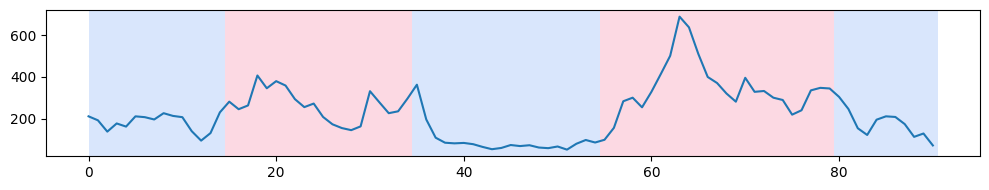

In [18]:
signal = user_counts[2].values
algo = rpt.Pelt(model="rbf").fit(signal)
breakpoints = algo.predict(pen=2)
rpt.display(signal, breakpoints)
user_counts.index[breakpoints[:-1]]

- Cohort 1: until 2000- 04 - 16
Small install volume, slow level progression, fewer milestone completions.
- Cohort 2: 2000-04-16 to 2000-05-11
Install volume increases, level progression improves, early signs of reward-driven behavior.
- Cohort 3: 2000-05-11 to 2000-05-26
Mid-level installs, mixed engagement, moderate improvement in time to milestones.
- Cohort 4: 2000-05-26 to 2000-06-20
Peak installs, highest level completion counts, fastest progression — likely most impacted by incentive optimization.
- Cohort 5: from 2000-06-20
Install volume declining or stabilizing, limited time to reach milestones, behavior partially observed

In [19]:
def assign_cohort(install_date):
    if install_date < date(2000,4,16):
        return '1'
    elif install_date < date(2000,5,11):
        return '2'
    elif install_date < date(2000,5,26):
        return '3'
    elif install_date < date(2000,6,20):
        return '4'
    else:
        return '5'

eda_df['cohort'] = eda_df['install_date'].apply(assign_cohort)

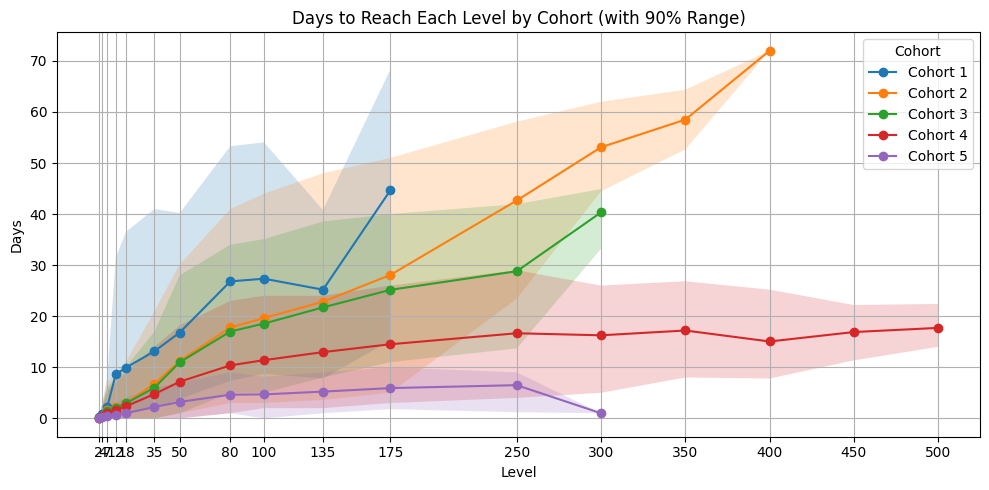

In [20]:
# Extract level columns and levels
level_cols = [col for col in eda_df.columns if col.startswith('days_to_reach_level_')]
level_nums = [int(col.split('_')[-1]) for col in level_cols]

# Prepare long-form data (melt and extract level)
eda_long = eda_df[['cohort'] + level_cols].melt(id_vars='cohort', 
                                                 var_name='level_col', 
                                                 value_name='days')

# Extract level numbers from level_col
eda_long['level'] = eda_long['level_col'].str.extract(r'(\d+)').astype(int)

# Aggregate stats per cohort and level
summary_stats = eda_long.groupby(['cohort', 'level']).agg(
    mean=('days', 'mean'),
    q5=('days', lambda x: x.quantile(0.05)),
    q95=('days', lambda x: x.quantile(0.95))
).reset_index()

# Plot the data
plt.figure(figsize=(10, 5))

for cohort in summary_stats['cohort'].unique():
    data = summary_stats[summary_stats['cohort'] == cohort]
    
    # Plot mean days to reach each level
    plt.plot(data['level'], data['mean'], marker='o', label=f'Cohort {cohort}')
    
    # Plot the range between the 5th and 95th percentiles
    plt.fill_between(data['level'], data['q5'], data['q95'], alpha=0.2)

# Final touches on the plot
plt.title('Days to Reach Each Level by Cohort (with 90% Range)')
plt.xlabel('Level')
plt.ylabel('Days')
plt.legend(title='Cohort')
plt.grid(True)
plt.xticks(sorted(summary_stats['level'].unique()))
plt.tight_layout()
plt.show()


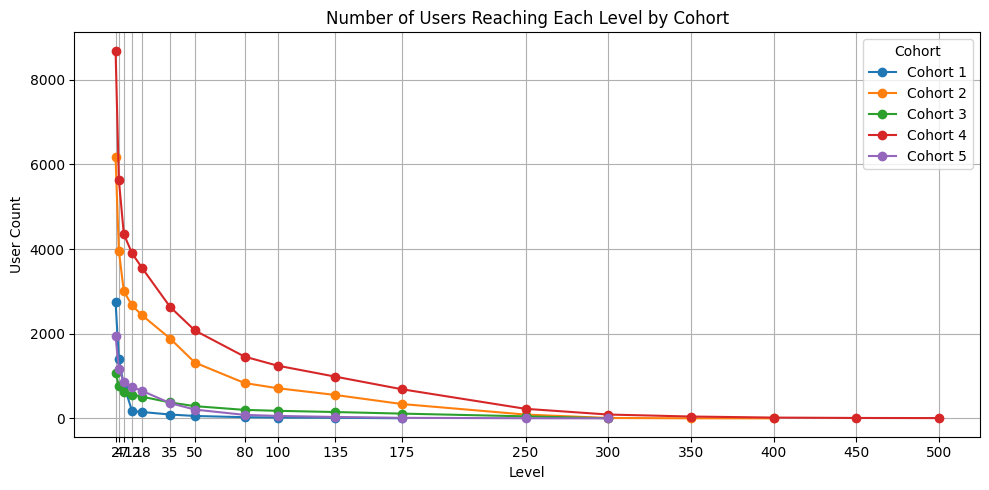

In [21]:
# Step 1: Count the number of users per cohort and level
user_counts = eda_long.dropna(subset=['days']) \
    .groupby(['cohort', 'level'])['days'] \
    .count() \
    .reset_index(name='user_count')

# Step 2: Plot the user counts
plt.figure(figsize=(10, 5))

# Loop over each cohort and plot
for cohort in sorted(user_counts['cohort'].unique()):
    cohort_data = user_counts[user_counts['cohort'] == cohort]
    plt.plot(cohort_data['level'], cohort_data['user_count'], marker='o', label=f'Cohort {cohort}')

# Final touches on the plot
plt.title('Number of Users Reaching Each Level by Cohort')
plt.xlabel('Level')
plt.ylabel('User Count')
plt.grid(True)
plt.legend(title='Cohort')
plt.xticks(sorted(user_counts['level'].unique()))
plt.tight_layout()

# Show plot
plt.show()


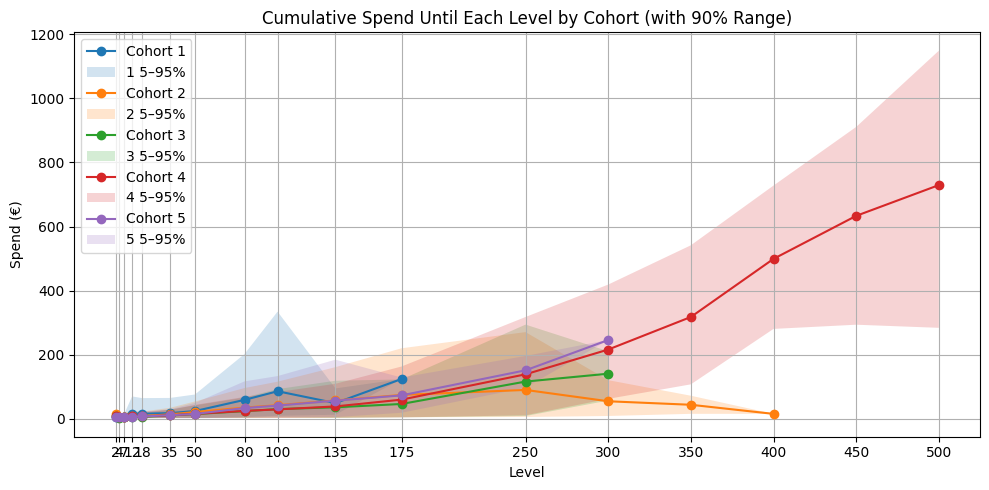

In [22]:
# Step 1: Identify the spend columns and corresponding levels
spend_cols = [col for col in eda_df.columns if col.startswith('purchase_until_reach_level_')]
level_nums = [int(col.split('_')[-1]) for col in spend_cols]

# Step 2: Melt the data to long format for easier analysis
spend_long = eda_df[['cohort'] + spend_cols].melt(id_vars='cohort', 
                                                  var_name='level_col', 
                                                  value_name='spend')

# Extract level numbers from the level column
spend_long['level'] = spend_long['level_col'].str.extract(r'(\d+)').astype(int)

# Step 3: Drop rows with missing spend values
spend_long = spend_long.dropna(subset=['spend'])

# Step 4: Aggregate spend statistics per cohort and level
spend_stats = (
    spend_long.groupby(['cohort', 'level'])['spend']
    .agg(mean='mean', p05=lambda x: x.quantile(0.05), p95=lambda x: x.quantile(0.95))
    .reset_index()
)

# Step 5: Plot the data
plt.figure(figsize=(10, 5))

# Loop through each cohort and plot the spend statistics
for cohort in sorted(spend_stats['cohort'].unique()):
    cohort_data = spend_stats[spend_stats['cohort'] == cohort]
    
    # Plot the mean spend for each level
    plt.plot(cohort_data['level'], cohort_data['mean'], marker='o', label=f'Cohort {cohort}')
    
    # Plot the range between the 5th and 95th percentiles
    plt.fill_between(cohort_data['level'], cohort_data['p05'], cohort_data['p95'], 
                     alpha=0.2, label=f'{cohort} 5–95%')

# Final touches on the plot
plt.title('Cumulative Spend Until Each Level by Cohort (with 90% Range)')
plt.xlabel('Level')
plt.ylabel('Spend (€)')
plt.grid(True)
plt.legend()
plt.xticks(sorted(spend_stats['level'].unique()))
plt.tight_layout()

# Show the plot
plt.show()



## Customers reaching key levels (CR)

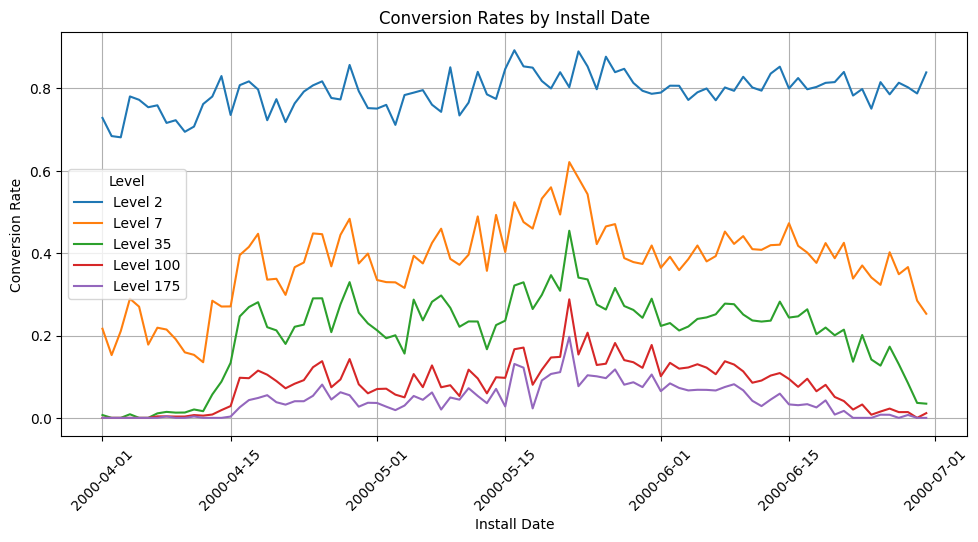

In [23]:
# Calculate number of installs per day
installs_per_day = (
    eda_df.groupby('install_date')
    .size()
    .reset_index(name='installs')
)

# Ensure column order
installs_per_day = installs_per_day[['install_date', 'installs']]

# Count of users reaching each level per day
level_counts_df = compute_level_metric_by_install(
    df=eda_df,
    metric_col_template='days_to_reach_level_{}',
    key_levels=key_levels,
    agg_func='size'  # counts
)

# Compute conversion rates by dividing by installs
conversion_rates = level_counts_df.div(installs_per_day.set_index('install_date')['installs'], axis=0)

# Plot conversion rates
plot_level_lines(
    pivot_df=conversion_rates,
    key_levels=key_levels,
    title='Conversion Rates by Install Date',
    ylabel='Conversion Rate'
)


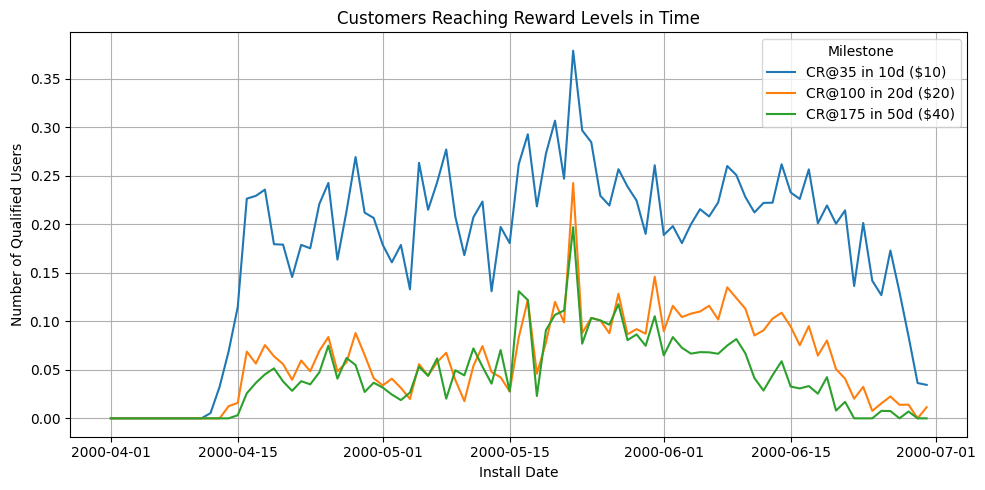

In [24]:
# Define conditions for reaching levels within required days
conditions = {
    'level_35': ('days_to_reach_level_35', 10),
    'level_100': ('days_to_reach_level_100', 20),
    'level_175': ('days_to_reach_level_175', 50)
}

# Initialize result DataFrame with install date and total installs
result_df = eda_df.groupby('install_date').size().reset_index(name='total_installs')

# For each condition, count how many users per install date met the criteria
for col_name, (days_col, day_limit) in conditions.items():
    if days_col in eda_df.columns:
        qualified = eda_df[eda_df[days_col] <= day_limit]
        counts = qualified.groupby('install_date').size().reset_index(name=col_name)
        result_df = result_df.merge(counts, on='install_date', how='left')

# Fill NaNs with 0
result_df.fillna(0, inplace=True)

# Optional: Convert install_date back to datetime for sorting or plotting
result_df['install_date'] = pd.to_datetime(result_df['install_date'])

plt.figure(figsize=(10, 5))

plt.plot(result_df['install_date'], (result_df['level_35']/result_df['total_installs']), label='CR@35 in 10d ($10)')
plt.plot(result_df['install_date'], (result_df['level_100']/result_df['total_installs']), label='CR@100 in 20d ($20)')
plt.plot(result_df['install_date'], (result_df['level_175']/result_df['total_installs']), label='CR@175 in 50d ($40)')

plt.title('Customers Reaching Reward Levels in Time')
plt.xlabel('Install Date')
plt.ylabel('Number of Qualified Users')
plt.grid(True)
plt.legend(title='Milestone')
plt.tight_layout()
plt.show()

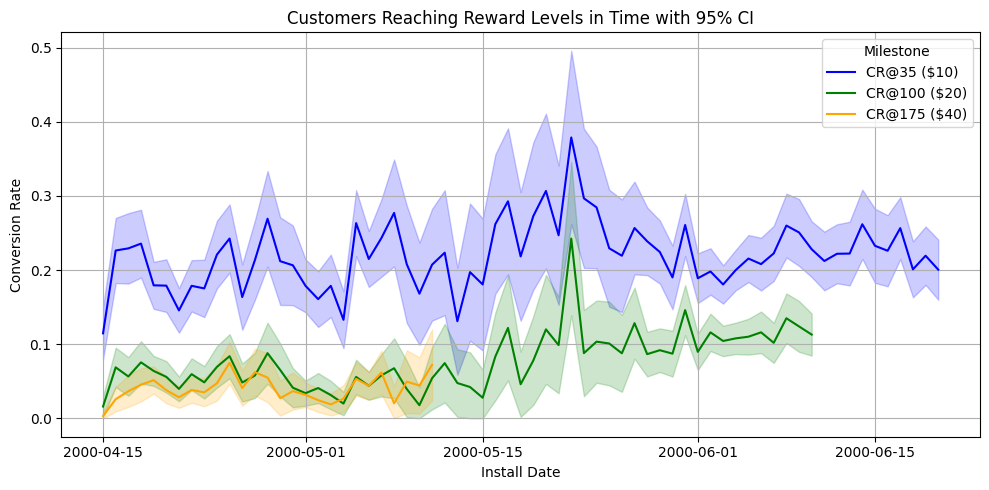

In [25]:

remove_start = result_df.query('install_date >= "2000-04-15"').copy()
remove_start['level_35'] = remove_start['level_35'].iloc[:-10]
remove_start['level_100'] = remove_start['level_100'].iloc[:-20]
remove_start['level_175'] = remove_start['level_175'].iloc[:-50]

# Compute conversion rates and Wilson confidence intervals
for lvl in [35, 100, 175]:
    conv = f'cr_{lvl}'
    low = f'cr_{lvl}_low'
    high = f'cr_{lvl}_high'
    
    remove_start[conv] = remove_start[f'level_{lvl}'] / remove_start['total_installs']
    
    ci = remove_start.apply(
        lambda row: proportion_confint(
            count=row[f'level_{lvl}'],
            nobs=row['total_installs'],
            alpha=0.05,
        ), axis=1)
    
    remove_start[low], remove_start[high] = zip(*ci)

# Plot
plt.figure(figsize=(10, 5))

for lvl, color in zip([35, 100, 175], ['blue', 'green', 'orange']):
    conv = f'cr_{lvl}'
    low = f'cr_{lvl}_low'
    high = f'cr_{lvl}_high'
    
    plt.plot(remove_start['install_date'], remove_start[conv], label=f'CR@{lvl} (${10 if lvl==35 else 20 if lvl==100 else 40})', color=color)
    plt.fill_between(remove_start['install_date'], remove_start[low], remove_start[high], color=color, alpha=0.2)

plt.title('Customers Reaching Reward Levels in Time with 95% CI')
plt.xlabel('Install Date')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.legend(title='Milestone')
plt.tight_layout()
plt.show()


## Payments

In [26]:
installs = df_clean.loc[
    (df_clean['action_type'] == 'install') & (df_clean['event_name'] == 'install')
][['user_id', 'action_datetime']].rename(columns={'action_datetime': 'install_datetime'})

purchases = df_clean.query('action_type == "purchase"')[["user_id", "action_value", "action_datetime"]]

temp = purchases.merge(
    installs,
    on="user_id",
    how="left"
)

temp['delta_install'] = (temp['action_datetime'] - temp['install_datetime']).dt.days

temp.query('delta_install <= 30').groupby(['user_id', 'delta_install'])['action_value'].sum().reset_index(name='total_spend')

pivoted = (
    temp.query('delta_install <= 30')
    .groupby(['user_id', 'delta_install'])['action_value']
    .sum()
    .reset_index(name='total_spend')
    .pivot(index='user_id', columns='delta_install', values='total_spend')
    .fillna(0)
)

# Optional: sort columns and ensure delta_install goes from 0 to 30
pivoted = pivoted.reindex(columns=range(31), fill_value=0)
pivoted.columns = [f'purchase_at_day_{day}' for day in pivoted.columns]

pivoted['2_day_spend'] = pivoted.iloc[:, :1].sum(axis=1)
pivoted['5_day_spend'] = pivoted.iloc[:, :4].sum(axis=1)
pivoted['10_day_spend'] = pivoted.iloc[:, :9].sum(axis=1)
pivoted['15_day_spend'] = pivoted.iloc[:, :14].sum(axis=1)
pivoted['30_day_spend'] = pivoted.sum(axis=1)

purchases_per_customer_30day = installs.merge(
    pivoted,
    on='user_id',
    how='left'
).fillna(0).fillna(0)

purchases_per_customer_30day['install_date'] = pd.to_datetime(purchases_per_customer_30day['install_datetime']).dt.date
purchases_per_customer_30day['cohort'] = purchases_per_customer_30day["install_date"].apply(assign_cohort)

up_to_date = ['2_day_spend','5_day_spend', '10_day_spend', '15_day_spend', '30_day_spend']

agg_df = purchases_per_customer_30day.groupby(['install_date', 'cohort'])[up_to_date].mean().reset_index()

<Axes: title={'center': 'Average Spend by customer app install date'}, xlabel='install_date'>

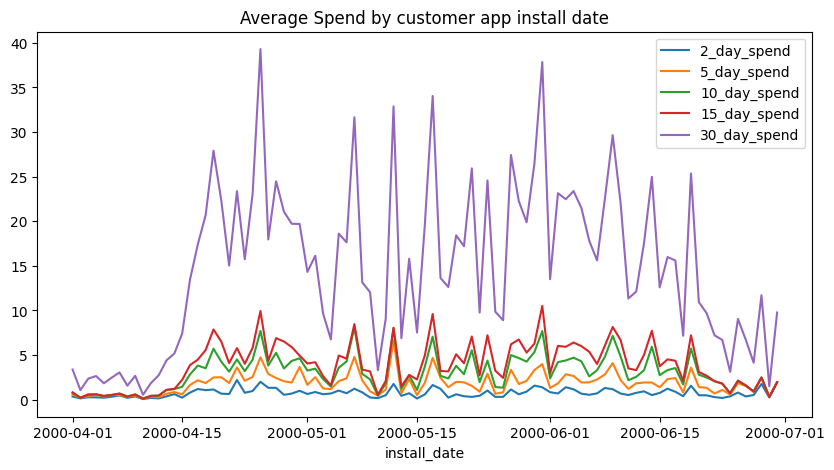

In [27]:
agg_df.plot(x='install_date', y=up_to_date, figsize=(10, 5), title='Average Spend by customer app install date')

##  Overview 

- There are clear structural shifts in user behavior over time, which justify dividing users into distinct cohorts for further analysis.
- Cohort 1 exhibits low engagement and monetization, with poor conversion to key levels. As such, it will be excluded from further analysis.
- Caution is needed when interpreting data from Cohorts 4 and 5, as we do not yet have complete 30-day purchase data for these users. Additionally, reward eligibility is tied to milestones with long deadlines (e.g., 50 days for level 175), which further complicates early analysis.
- The number of users reaching level 2 appears relatively stable across cohorts (excluding Cohort 1), suggesting consistent early engagement. Progression to higher levels shows cohort-dependent variation but remains broadly correlated across key milestones.
- A similar pattern is observed in monetization data — while early payments are stable, later-stage purchases may be influenced by cohort-specific factors and reward timing.


# Predict customer in_game purchases they will make within 30 days


The goal of this analysis is to **forecast the average 30-day in-game spend per customer** for users who will start their offer **on or after July 1st**.

This is a **cohort-based forecasting task**, where we use historical data on prior customer cohorts to estimate future performance. Each historical cohort is defined by the offer start date (install date), and we track their cumulative spend over a fixed 30-day period.

few key points:
- I should ignore all customers who started in the past 30 days, because we dont have full purchase history (Or mybe not?)
- I should ignore customers in the 1st cohort because they do not represent our current customer base 
- I should be cautious about cohort 3 with low number of customers, also cohort 4 with high number of customers 

In [28]:
purchases_per_customer_30day_filtered = purchases_per_customer_30day[(purchases_per_customer_30day.cohort != '1') & (purchases_per_customer_30day.install_date < date(2000,6,20))][['cohort', 'install_date', '2_day_spend', '5_day_spend', '10_day_spend', '15_day_spend', '30_day_spend']]

First I want to compare means between cohorts. This might reviel if there are any major differences between cohorts

In [29]:

def bootstrap_ci(series, n_bootstrap=1000, confidence=0.95):
    series = series.dropna().values
    means = [np.mean(np.random.choice(series, size=len(series), replace=True)) for _ in range(n_bootstrap)]
    lower = np.percentile(means, (1 - confidence) / 2 * 100)
    upper = np.percentile(means, (1 + confidence) / 2 * 100)
    return pd.Series({'mean': np.mean(series), 'ci_lower': lower, 'ci_upper': upper})

# Select relevant columns
spend_cols = ['2_day_spend', '5_day_spend', '10_day_spend', '15_day_spend', '30_day_spend']

# Group by cohort and calculate stats
summary = purchases_per_customer_30day_filtered.groupby('cohort')[spend_cols].apply(
    lambda df: df.apply(bootstrap_ci)
).unstack()

# Tidy up column names
summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]

# Display result
print(summary)


        2_day_spend_mean  2_day_spend_ci_lower  2_day_spend_ci_upper  \
cohort                                                                 
2               0.991586              0.800498              1.242869   
3               0.709815              0.487608              1.018477   
4               0.933457              0.802597              1.071743   

        5_day_spend_mean  5_day_spend_ci_lower  5_day_spend_ci_upper  \
cohort                                                                 
2               2.397595              1.985707              2.832542   
3               2.138585              1.358868              3.149167   
4               2.296591              2.038523              2.592123   

        10_day_spend_mean  10_day_spend_ci_lower  10_day_spend_ci_upper  \
cohort                                                                    
2                4.023389               3.496094               4.641795   
3                3.356569               2.321503     

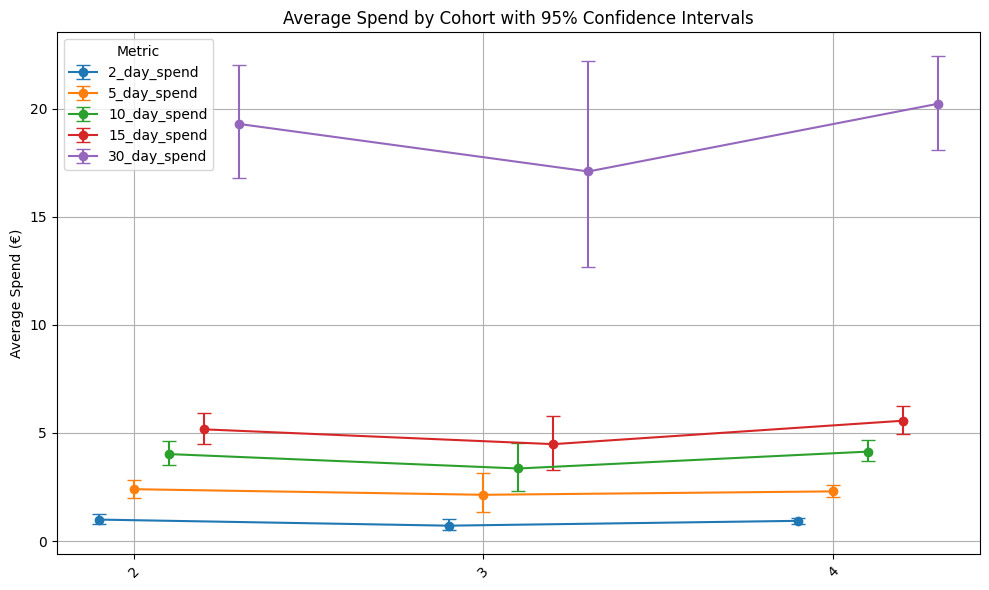

In [30]:
import matplotlib.pyplot as plt

# Extract spend metrics
metrics = ['2_day_spend', '5_day_spend', '10_day_spend', '15_day_spend', '30_day_spend']

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each metric
for metric in metrics:
    means = summary[f'{metric}_mean']
    lowers = summary[f'{metric}_ci_lower']
    uppers = summary[f'{metric}_ci_upper']
    
    # X positions
    x = np.arange(len(summary.index))
    
    # Offset each line slightly to avoid overlap
    offset = metrics.index(metric) * 0.1
    x_offset = x + offset
    
    plt.errorbar(x_offset, means, 
                 yerr=[means - lowers, uppers - means], 
                 fmt='o-', capsize=5, label=metric)

# Format plot
plt.xticks(np.arange(len(summary.index)) + 0.1, summary.index, rotation=45)
plt.ylabel("Average Spend (€)")
plt.title("Average Spend by Cohort with 95% Confidence Intervals")
plt.grid(True)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


The means are similar across all cohorts, so technically, I could use the overall mean as my predictor.

However, the daily trends also appear consistent. I might be able to use 10-day purchase data to predict 30-day purchases, which could yield tighter confidence intervals. This approach would allow me to capture trends closer to July 1st and evaluate whether the cohort-wide mean is truly a meaningful predictor.

In [31]:
user_counts_filtered = purchases_per_customer_30day_filtered.groupby('install_date').count()['cohort'].reset_index(name='user_count')

In [32]:
agg_df = agg_df.merge(
    user_counts_filtered,
    on='install_date',
    how='left'
)

In [33]:


agg_df_filtered_30 = agg_df[(agg_df['install_date'] < date(2000, 6, 1)) & (agg_df['cohort'] != '1')].copy()

X = agg_df_filtered_30['10_day_spend']
y = agg_df_filtered_30['30_day_spend']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           30_day_spend   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     689.1
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.63e-28
Time:                        18:20:35   Log-Likelihood:                -97.506
No. Observations:                  46   AIC:                             199.0
Df Residuals:                      44   BIC:                             202.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2523      0.700      3.218      0.002       0.842       3.663
10_day_spend     4.3270      0.165     26.250      0.000       3.995       4.659
==============================================================================
Omnibus:                        0.799   Durbin-Watson:                   1.427
Prob(Omnibus):                  0.671   Jarque-Bera (JB):                0.354
Skew:                          -0.205   Prob(JB):                        0.838
Kurtosis:                       3.128   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
X = agg_df_filtered_30['2_day_spend']
y = agg_df_filtered_30['30_day_spend']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           30_day_spend   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     52.14
Date:                Wed, 07 May 2025   Prob (F-statistic):           5.43e-09
Time:                        18:20:35   Log-Likelihood:                -144.23
No. Observations:                  46   AIC:                             292.5
Df Residuals:                      44   BIC:                             296.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.7958      1.740      4.481      0.000       4.289      11.302
2_day_spend    12.7131      1.761      7.221      0.000       9.165      16.261
==============================================================================
Omnibus:                        0.394   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.214
Skew:                           0.166   Prob(JB):                        0.898
Kurtosis:                       2.955   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
X = agg_df_filtered_30['user_count']
y = agg_df_filtered_30['30_day_spend']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           30_day_spend   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.192
Date:                Wed, 07 May 2025   Prob (F-statistic):             0.0809
Time:                        18:20:35   Log-Likelihood:                -160.60
No. Observations:                  46   AIC:                             325.2
Df Residuals:                      44   BIC:                             328.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2608      2.316      6.589      0.000      10.593      19.929
user_count     0.0148      0.008      1.787      0.081      -0.002       0.031
==============================================================================
Omnibus:                        3.664   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.234
Skew:                           0.647   Prob(JB):                        0.198
Kurtosis:                       2.896   Cond. No.                         541.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
X = agg_df_filtered_30[['10_day_spend']].values  # make sure it's 2D
y = agg_df_filtered_30['30_day_spend'].values

# Initialize model and cross-validator
model = LinearRegression()
loo = LeaveOneOut()

# Store errors
errors = []
predictions = []
truths = []

# Perform LOOCV manually
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.append(y_pred[0])
    truths.append(y_test[0])
    errors.append(y_test[0] - y_pred[0])

# Convert to DataFrame
cv_results = pd.DataFrame({
    'true': truths,
    'predicted': predictions,
    'error': errors
})

# Print summary
mse = np.mean(np.square(cv_results['error']))
print(f"LOOCV Mean Squared Error: {mse:.4f}")

# 95% Confidence Interval for the prediction error (percentile-based)
lower, upper = np.percentile(cv_results['error'], [2.5, 97.5])
print(f"95% CI for Prediction Error: ({lower:.4f}, {upper:.4f})")


LOOCV Mean Squared Error: 4.6999
95% CI for Prediction Error: (-4.6299, 3.7297)


/Users/martynaslukosevicius/Almedia/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


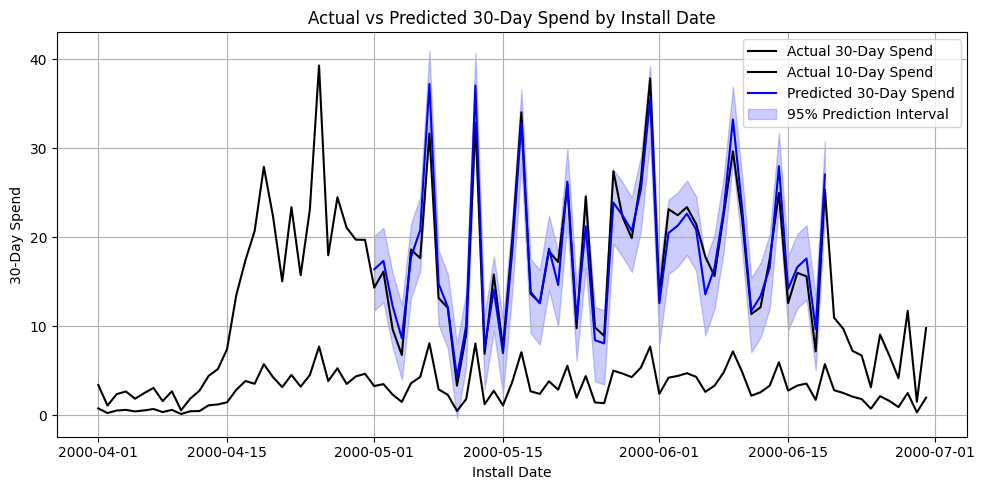

In [37]:
predict_df = agg_df[(agg_df['install_date'] >= date(2000, 5, 1)) & 
                    (agg_df['install_date'] < date(2000, 6, 20))][['install_date', '10_day_spend']]

# Predict
model.fit(X, y)
predictions = model.predict(predict_df[['10_day_spend']])

# Build result DataFrame
prediction_result = predict_df.copy()
prediction_result['predicted_30_day_spend'] = predictions

# Add constant CI interval (you can improve this by modeling heteroskedasticity if needed)
lower_bound = predictions + (-4.6299)
upper_bound = predictions + 3.7297
prediction_result['lower_95'] = lower_bound
prediction_result['upper_95'] = upper_bound

prediction_result.set_index('install_date', inplace=True)

# 1. Actuals (full set)
actuals = agg_df[['install_date', '30_day_spend', '10_day_spend']].set_index('install_date')

# 2. Predictions (already computed in prediction_result)
# Ensure prediction_result is already indexed by install_date

# 3. Plot
plt.figure(figsize=(10, 5))
plt.plot(actuals.index, actuals['30_day_spend'], label='Actual 30-Day Spend', color='black')
plt.plot(actuals.index, actuals['10_day_spend'], label='Actual 10-Day Spend', color='black')

# Only plot predictions in their date range
plt.plot(prediction_result.index, prediction_result['predicted_30_day_spend'], label='Predicted 30-Day Spend', color='blue')
plt.fill_between(prediction_result.index,
                 prediction_result['lower_95'],
                 prediction_result['upper_95'],
                 color='blue', alpha=0.2, label='95% Prediction Interval')

plt.title('Actual vs Predicted 30-Day Spend by Install Date')
plt.xlabel('Install Date')
plt.ylabel('30-Day Spend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:

# Your data
X = agg_df_filtered_30[['5_day_spend']].values  # make sure it's 2D
y = agg_df_filtered_30['30_day_spend'].values

# Initialize model and cross-validator
model = LinearRegression()
loo = LeaveOneOut()

# Store errors
errors = []
predictions = []
truths = []

# Perform LOOCV manually
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.append(y_pred[0])
    truths.append(y_test[0])
    errors.append(y_test[0] - y_pred[0])

# Convert to DataFrame
cv_results = pd.DataFrame({
    'true': truths,
    'predicted': predictions,
    'error': errors
})

# Print summary
mse = np.mean(np.square(cv_results['error']))
print(f"LOOCV Mean Squared Error: {mse:.4f}")

# 95% Confidence Interval for the prediction error (percentile-based)
lower, upper = np.percentile(cv_results['error'], [2.5, 97.5])
print(f"95% CI for Prediction Error: ({lower:.4f}, {upper:.4f})")

LOOCV Mean Squared Error: 22.5172
95% CI for Prediction Error: (-7.0947, 9.8538)


/Users/martynaslukosevicius/Almedia/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


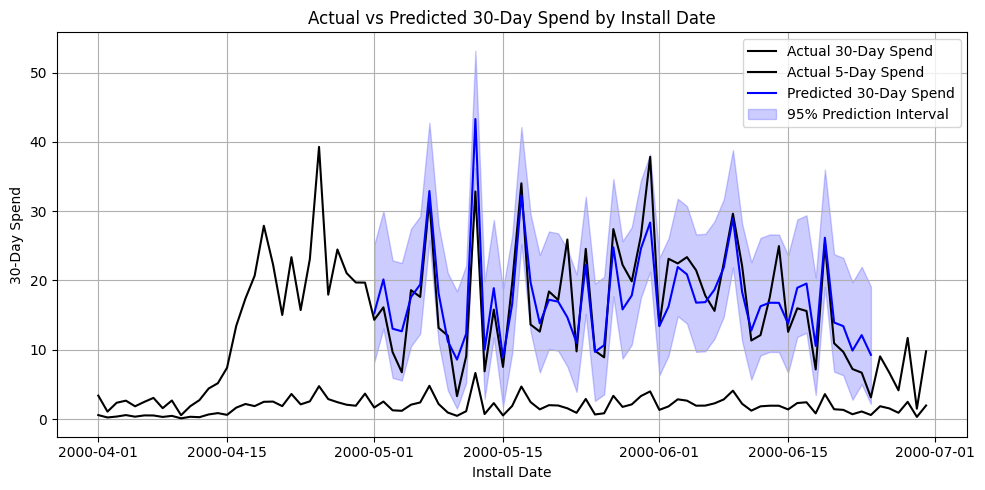

In [39]:

# Filter prediction data
predict_df = agg_df[(agg_df['install_date'] >= date(2000, 5, 1)) & 
                    (agg_df['install_date'] < date(2000, 6, 25))][['install_date', '5_day_spend']]

# Predict
model.fit(X, y)
predictions = model.predict(predict_df[['5_day_spend']])

# Build result DataFrame
prediction_result = predict_df.copy()
prediction_result['predicted_30_day_spend'] = predictions

# Add constant CI interval (you can improve this by modeling heteroskedasticity if needed)
lower_bound = predictions + (-7.0947)
upper_bound = predictions + 9.8538
prediction_result['lower_95'] = lower_bound
prediction_result['upper_95'] = upper_bound

prediction_result.set_index('install_date', inplace=True)
import matplotlib.pyplot as plt

# 1. Actuals (full set)
actuals = agg_df[['install_date', '30_day_spend', '5_day_spend']].set_index('install_date')

# 2. Predictions (already computed in prediction_result)
# Ensure prediction_result is already indexed by install_date

# 3. Plot
plt.figure(figsize=(10, 5))
plt.plot(actuals.index, actuals['30_day_spend'], label='Actual 30-Day Spend', color='black')
plt.plot(actuals.index, actuals['5_day_spend'], label='Actual 5-Day Spend', color='black')

# Only plot predictions in their date range
plt.plot(prediction_result.index, prediction_result['predicted_30_day_spend'], label='Predicted 30-Day Spend', color='blue')
plt.fill_between(prediction_result.index,
                 prediction_result['lower_95'],
                 prediction_result['upper_95'],
                 color='blue', alpha=0.2, label='95% Prediction Interval')

plt.title('Actual vs Predicted 30-Day Spend by Install Date')
plt.xlabel('Install Date')
plt.ylabel('30-Day Spend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on our predictions using 10-day and 5-day purchase data to forecast 30-day purchases, there is no clear evidence that spending is changing — whether increasing or decreasing.

Additionally, the number of new client onboardings does not serve as a reliable predictor. As a result, I cannot conclude that the apparent drop in spending observed around 2000-06-15 is anything more than random variation.

In [40]:


data_pred = purchases_per_customer_30day[(purchases_per_customer_30day.cohort != '1') & (purchases_per_customer_30day.install_date < date(2000,6,1))]\
    .groupby(['install_date', 'cohort']).agg(
        mean=('30_day_spend', 'mean'),
    ).reset_index()

# purchases_per_customer_30day.groupby('install_date')['30_day_spend'].mean().reset_index(name='avg_30_day_spend')

<Axes: title={'center': 'Average Spend by Install Date'}, xlabel='install_date'>

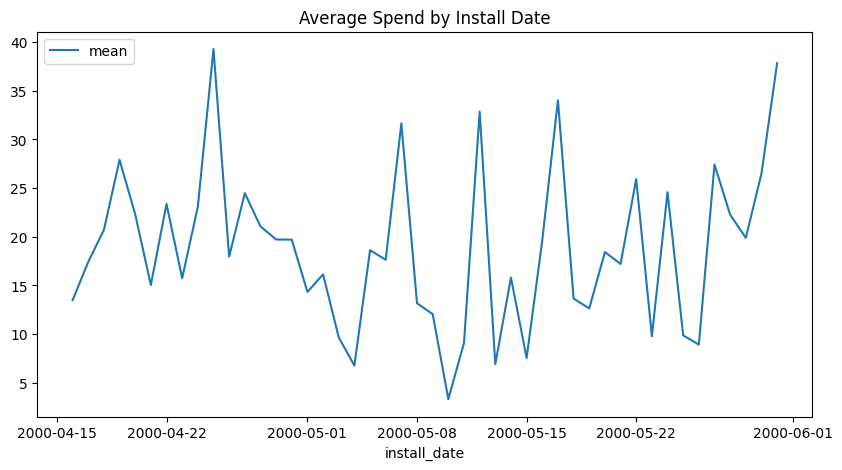

In [41]:
data_pred.plot(x='install_date', y='mean', figsize=(10, 5), title='Average Spend by Install Date')

In [42]:
data_pred['install_date'] = pd.to_datetime(data_pred['install_date'])
data_pred['day_of_week'] = data_pred['install_date'].dt.dayofweek
data_pred_daily = data_pred.copy()
data_pred_daily.reset_index(inplace=True)
data_pred_daily.drop(columns=['install_date'], inplace=True)
data_pred_daily = pd.get_dummies(data_pred_daily, columns=['cohort', 'day_of_week'], drop_first=True).astype('float')


In [43]:
X = data_pred_daily.drop(columns=['mean'])
y = data_pred_daily['mean']
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.7965
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.622
Time:                        18:20:35   Log-Likelihood:                -158.03
No. Observations:                  46   AIC:                             336.1
Df Residuals:                      36   BIC:                             354.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.4049      4.252      4.799      0.000      11.782      29.027
index            -0.2927      0.216     -1.355      0.184      -0.731       0.145
cohort_3          4.9011      5.164      0.949      0.349      -5.571      15.373
cohort_4         13.7194      7.649      1.794      0.081      -1.794      29.233
day_of_week_1     3.5392      4.544      0.779      0.441      -5.676      12.755
day_of_week_2     5.4357      4.559      1.192      0.241      -3.811      14.682
day_of_week_3    -2.2135      4.778     -0.463      0.646     -11.903       7.476
day_of_week_4     0.4396      4.734      0.093      0.927      -9.162      10.042
day_of_week_5     1.4577      4.728      0.308      0.760      -8.131      11.046
day_of_week_6     1.7763      4.544      0.391      0.698      -7.439      10.992
==============================================================================
Omnibus:                        1.118   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                0.810
Skew:                           0.324   Prob(JB):                        0.667
Kurtosis:                       2.958   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression model explained only 16.6% of the variance in mean, with no significant predictors overall. While cohort_4 showed a potential positive effect, the result was only borderline significant. No strong weekly seasonality was found.

In [44]:

adf_result = adfuller(data_pred_daily['mean'].dropna())
print(f"ADF p-value: {adf_result[1]}")


ADF p-value: 4.313271133780619e-07


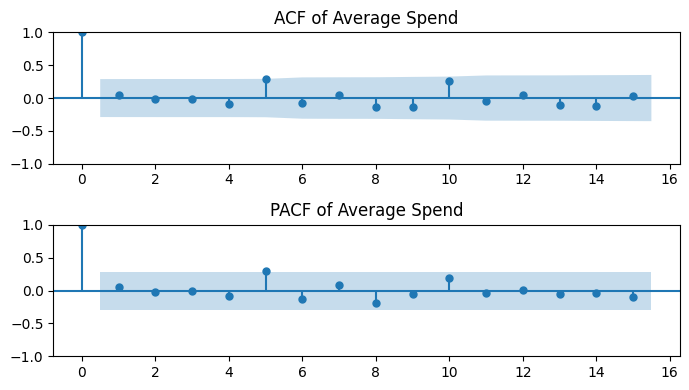

In [45]:


# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(7, 4))

# Drop missing values just in case
plot_acf(data_pred_daily['mean'].dropna(), lags=15, ax=axes[0])
axes[0].set_title('ACF of Average Spend')

plot_pacf(data_pred_daily['mean'].dropna(), lags=15, ax=axes[1])
axes[1].set_title('PACF of Average Spend')

plt.tight_layout()
plt.show()


Data is stationary, no seasonalities and autocorrelations 

In [46]:
X = np.arange(0, len(data_pred_daily), 1).reshape(-1, 1)
y = data_pred_daily['mean'].values
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                  0.003517
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.953
Time:                        18:20:35   Log-Likelihood:                -162.20
No. Observations:                  46   AIC:                             328.4
Df Residuals:                      44   BIC:                             332.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6781      2.440      7.654      0.000      13.760      23.596
x1             0.0055      0.093      0.059      0.953      -0.183       0.194
==============================================================================
Omnibus:                        2.251   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.891
Skew:                           0.494   Prob(JB):                        0.388
Kurtosis:                       2.889   Cond. No.                         51.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No trend also 

Because there is no seasonality, no autocorrelation, and no trend, we can use **mean** value as a **average 30-day in-game spend per customer**

In [47]:
data_for_mean_pred = purchases_per_customer_30day_filtered[purchases_per_customer_30day_filtered['install_date'] < date(2000,6,1)]['30_day_spend']


In [48]:
train, test = train_test_split(data_for_mean_pred, test_size=0.2, random_state=42)

mean_pred = train.mean()
predictions = [mean_pred] * len(test)

# Evaluate
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

boot_means = [train.sample(frac=1, replace=True).mean() for _ in range(1000)]
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"Mean: {mean_pred} RMSE: {rmse}, CI: ({ci_lower}, {ci_upper})")

Mean: 20.273574265289913 RMSE: 103.67282730133266, CI: (17.841019289685693, 22.843255559968227)


In [49]:
np.percentile(purchases_per_customer_30day_filtered[purchases_per_customer_30day_filtered['install_date'] < date(2000,6,1)]['30_day_spend'], q = [2.5, 97.5])

array([  0.  , 202.91])

The primary goal of this task is to predict the expected in-game spend per customer within the first 30 days after starting an offer. The forecast will be applied to customers who begin their offer from July 1st onward.

- Customers who started within the past 30 days prior to July 1st were excluded, as we do not yet have their complete 30-day purchase history. Including these users would bias the model due to partial data.
- Cohort 1  was excluded because their behavior significantly differs from the current customer base, and they do not represent present-day performance.

### Boostrap analysis: 
- For each cohort, we computed bootstrap confidence intervals around mean 30-day spend.
- The mean 30-day spend was statistically similar across all cohorts. No significant differences were observed.

### Modelling:

- Regression models were trained to predict 30-day spend per install using 5-day and 10-day spend per install.
- The models were robust but did not reveal any decline in spend behavior for customers starting in June, indicating that June installs were not significantly different in value.

- Attempts to predict 30-day spend using the number of installs yielded poor model performance

- We assessed whether daily 30-day spend per install exhibits seasonality or trend
    - ADF test p-value = 4.31e-07.  Strong evidence that the series is stationary
    - Autocorrelation (ACF) and partial autocorrelation (PACF) plots did not show strong temporal dependencies
    - Simple linear regression also failed to reveal any significant upward or downward trend.


### Final model

Given the above findings, a mean-based prediction model was adopted

### Result:

- For customers installing the app from July 1st onwards, the predicted average 30-day in-game spend per customer is $20.27.
- The 95% confidence interval for the mean is ($17.80, $22.80), suggesting a reasonably stable central estimate.
- However, individual spend varies widely, with a 95% prediction interval of ($0.00, $202.91).

Caution: While current patterns support this prediction, customer spending behavior may evolve over time due to factors like seasonality, promotions, or product changes. This forecast should be regularly updated as new data becomes available.



# Expected Customer Payout 

We aim to estimate the **expected average payout (user rewards)** for customers starting the offer on **July 1st**, one day after the current dataset ends.

The **Expected Customer Payout (ECP)** is defined as:

ECP= CR@35 * 10 + CR@100 * 20 + CR@175 * 40 , where CR@x is proportion of all customers who managed to reach a level on time 

Challenges in Estimating Future Conversion Rates

Predicting CR values for users starting on July 1st involves several complexities:

1. **Censored data due to level deadlines**  
   Customers must reach levels within specific timeframes (10, 20, and 50 days).
   - The deadline for reaching **level 35 (10 days)** has minimal impact on recent data.
   - For **level 175 (50 days)**, many users haven't had enough time to complete the journey, resulting in **right-censoring**.

2. **Anomalous or unreliable time periods**  
   - In **Cohort 1**, there were **no conversions** for levels 100 and 175.  
   - In **Cohort 3**, **low user volume** increases uncertainty in conversion rates. This likely explains the anomaly observed around **May 20th**.

### Estimation Approach

- Use **daily conversion rates** to estimate CR@x.
- When possible, base predictions on the **most recent cohorts**, as user behavior may evolve over time.
- This approach is suitable for **CR@35** and **CR@100**, but not for **CR@175** due to data censoring.
- To estimate CR@175, examine whether it is **correlated** with earlier conversion rates (e.g., CR@100). If a stable relationship exists, use this correlation to model CR@175, incorporating uncertainty accordingly.


## How to estimate CR@35 

To estimate for CR@35 in 10 days, I will use cohort 4 data except the last 10 days. First I will check if it has any trend. If there is no significant trend I can calculate mean as my predictor value 

In [50]:
filtered_data = remove_start[remove_start["install_date"] > pd.to_datetime("2000-05-26")]
filtered_data = filtered_data.reset_index(drop=True).dropna(subset=['cr_35'])
y = filtered_data['cr_35'].values
X = np.arange(len(y)).reshape(-1, 1)

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.07266
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.790
Time:                        18:20:36   Log-Likelihood:                 57.885
No. Observations:                  25   AIC:                            -111.8
Df Residuals:                      23   BIC:                            -109.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2208      0.010     22.837      0.000       0.201       0.241
x1             0.0002      0.001      0.270      0.790      -0.001       0.002
==============================================================================
Omnibus:                        2.345   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                1.289
Skew:                           0.208   Prob(JB):                        0.525
Kurtosis:                       1.969   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
X = np.arange(len(y)).reshape(-1, 1)
X_with_const = sm.add_constant(X)
X_const = X_with_const[:,0].reshape(-1, 1)
model = sm.OLS(y, X_const).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 07 May 2025   Prob (F-statistic):                nan
Time:                        18:20:36   Log-Likelihood:                 57.846
No. Observations:                  25   AIC:                            -113.7
Df Residuals:                      24   BIC:                            -112.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2231      0.005     45.677      0.000       0.213       0.233
==============================================================================
Omnibus:                        1.999   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.153
Skew:                           0.160   Prob(JB):                        0.562
Kurtosis:                       1.998   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No significant trend in the data. For this reason my predictor will be mean value

In [52]:
# LOOCV
residuals = []
models = []

for i in range(len(y)):
    y_train = np.delete(y, i)
    y_test = y[i]

    model = y_train.mean()
    models.append(model) 
    y_pred = model
    residuals.append(y_test - y_pred)

residuals = np.array(residuals)

# Calculate mean and confidence interval of out-of-sample residuals
rmse = (residuals**2).mean()**0.5
mean_prediction = np.mean(models)
model_35_std = np.std(models)

ci_lower = mean_prediction - 1.96 * model_35_std
ci_upper = mean_prediction + 1.96 * model_35_std

residuals_35_std = np.std(residuals)

prediction_lower = mean_prediction - 1.96 * residuals_35_std
prediction_upper = mean_prediction + 1.96 * residuals_35_std

print(f"Mean Prediction: {mean_prediction}, RMSE: {rmse}")
print(f"95% CI: ({ci_lower}, {ci_upper})")
print(f"Prediction Interval: ({prediction_lower}, {prediction_upper})")


Mean Prediction: 0.22308273945135706, RMSE: 0.024923120602143422
95% CI: (0.221128766796149, 0.22503671210656512)
Prediction Interval: (0.17423342307115597, 0.27193205583155816)


Given the model's mean prediction of 0.2231 and a narrow 95% confidence interval of (0.2211, 0.2250), we can conclude that the expected conversion rate for CR@35 is approximately 22.31%. The 95% prediction interval of (0.1742, 0.2719) indicates that most future observations are expected to fall within this range. The model's out-of-sample performance, with a low RMSE of 0.025, confirms that it provides a stable and accurate estimate for CR@35, with minimal variance and reliable generalization.

## How to estimate CR level 100 

Similarly to CR@35

In [53]:
filtered_data = remove_start[remove_start["install_date"] > pd.to_datetime("2000-05-26")]
filtered_data = filtered_data.reset_index(drop=True).dropna(subset=['cr_100'])
y = filtered_data['cr_100'].values
X = np.arange(len(y)).reshape(-1, 1)

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

model.summary()

/Users/martynaslukosevicius/Almedia/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.281
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.278
Time:                        18:20:36   Log-Likelihood:                 40.370
No. Observations:                  15   AIC:                            -76.74
Df Residuals:                      13   BIC:                            -75.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1022      0.009     11.795      0.000       0.083       0.121
x1             0.0012      0.001      1.132      0.278      -0.001       0.003
==============================================================================
Omnibus:                        3.714   Durbin-Watson:                   2.695
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.180
Skew:                           0.934   Prob(JB):                        0.336
Kurtosis:                       3.017   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
X = np.arange(len(y)).reshape(-1, 1)
X_with_const = sm.add_constant(X)
X_const = X_with_const[:,0].reshape(-1, 1)
model = sm.OLS(y, X_const).fit()

model.summary()

/Users/martynaslukosevicius/Almedia/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 07 May 2025   Prob (F-statistic):                nan
Time:                        18:20:36   Log-Likelihood:                 39.665
No. Observations:                  15   AIC:                            -77.33
Df Residuals:                      14   BIC:                            -76.62
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1105      0.005     24.051      0.000       0.101       0.120
==============================================================================
Omnibus:                        0.513   Durbin-Watson:                   2.440
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.576
Skew:                           0.326   Prob(JB):                        0.750
Kurtosis:                       2.294   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# LOOCV
residuals = []
models = []

for i in range(len(y)):
    y_train = np.delete(y, i)
    y_test = y[i]

    model = y_train.mean()
    models.append(model) 
    y_pred = model
    residuals.append(y_test - y_pred)

residuals = np.array(residuals)

# Calculate mean and confidence interval of out-of-sample residuals
rmse = (residuals**2).mean()**0.5
mean_prediction = np.mean(models)
model_100_std = np.std(models)

ci_lower = mean_prediction - 1.96 * model_100_std
ci_upper = mean_prediction + 1.96 * model_100_std

residuals_100_std = np.std(residuals)

prediction_lower = mean_prediction - 1.96 * residuals_100_std
prediction_upper = mean_prediction + 1.96 * residuals_100_std

print(f"Mean Prediction: {mean_prediction}, RMSE: {rmse}")
print(f"95% CI: ({ci_lower}, {ci_upper})")
print(f"Prediction Interval: ({prediction_lower}, {prediction_upper})")


Mean Prediction: 0.11051185536698238, RMSE: 0.01842066704990651
95% CI: (0.1081048882057946, 0.11291882252817016)
Prediction Interval: (0.07440734794916562, 0.14661636278479914)


Given the model's mean prediction of 0.1105, with a 95% confidence interval of (0.1081, 0.1129), we estimate that approximately 11.05% of users are expected to reach level 100 within the defined time. The 95% prediction interval of (0.0744, 0.1466) reflects the expected range for individual observations. The model’s RMSE of 0.0184 suggests low out-of-sample prediction error, indicating that the estimator is both stable and reliable for forecasting CR@100.

## How to estimate CR@175

While CR@35 and CR@100 were estimated without major issues, CR@175 presents a significant challenge due to limited data in the most recent cohorts.

There are several key points to consider:
- When forecasting the number of conversions, the predicted value should not be lower than the number of users who have already converted. 
- From visual inspection, CR@175 appears more closely correlated with CR@100 than with CR@35, which could inform our modeling approach.


In [56]:
# Prepare the data
mask = ~remove_start['cr_175'].isna()

X = remove_start['cr_100'][mask]
y = remove_start['cr_175'][mask]

X = sm.add_constant(X)  # Add constant for intercept
# Fit linear regression using statsmodels
model_100 = sm.OLS(y, X).fit()

# Get predictions
y_pred = model_100.predict(X)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred)**0.5

# Print regression summary
model_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cr_175   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     8.561
Date:                Wed, 07 May 2025   Prob (F-statistic):            0.00721
Time:                        18:20:36   Log-Likelihood:                 76.800
No. Observations:                  27   AIC:                            -149.6
Df Residuals:                      25   BIC:                            -147.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0172      0.008      2.031      0.053      -0.000       0.035
cr_100         0.4493      0.154      2.926      0.007       0.133       0.765
==============================================================================
Omnibus:                        0.154   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.338
Skew:                           0.132   Prob(JB):                        0.844
Kurtosis:                       2.519   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:

X = remove_start['cr_100'][mask]
y = remove_start['cr_175'][mask]

# Fit linear regression using statsmodels
model_100 = sm.OLS(y, X).fit()

# Get predictions
y_pred = model_100.predict(X)

# Calculate RMSE
rmse = mean_squared_error(y, y_pred)**0.5

# Print regression summary
print(model_100.summary())
# This ratio helps understand the relative magnitude of the error
# Lower values indicate better model performance relative to the data scale

                                 OLS Regression Results                                
Dep. Variable:                 cr_175   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              188.5
Date:                Wed, 07 May 2025   Prob (F-statistic):                    2.01e-13
Time:                        18:20:36   Log-Likelihood:                          74.738
No. Observations:                  27   AIC:                                     -147.5
Df Residuals:                      26   BIC:                                     -146.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

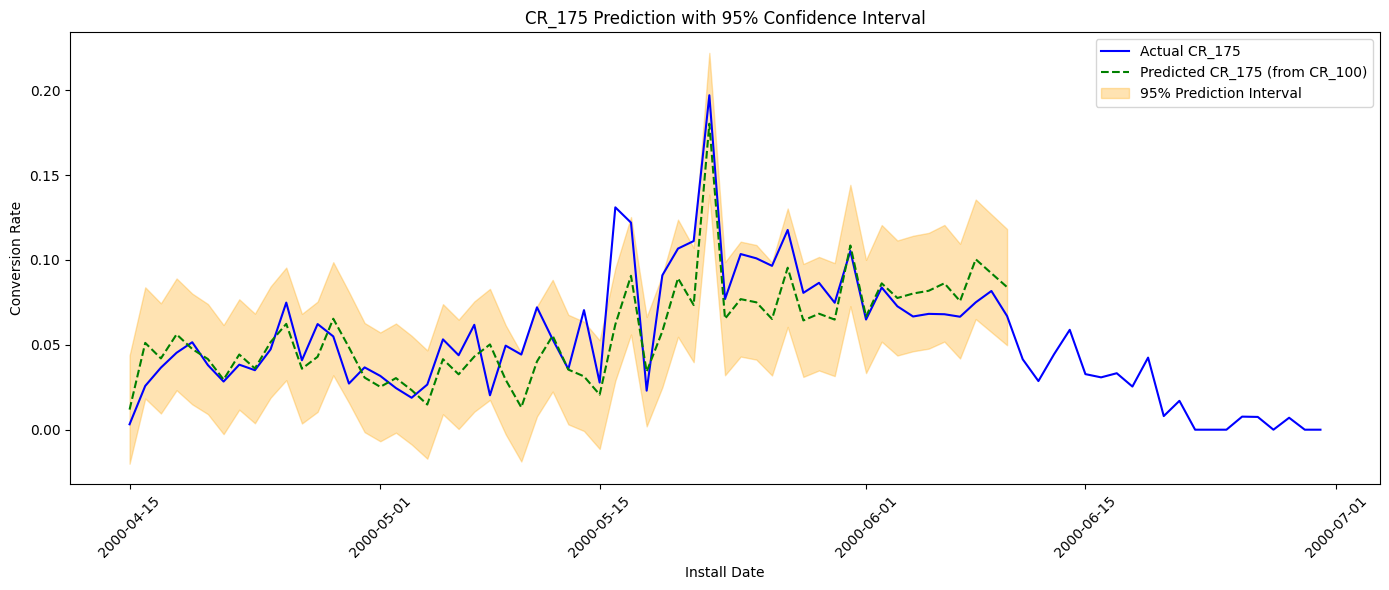

In [58]:
estimation = remove_start[['install_date', 'cr_100', 'cr_175']].copy()
estimation["prediction_100"] = model_100.predict(remove_start['cr_100'])
estimation["actual"] = result_df['level_175'] / result_df['total_installs']
predictions = model_100.get_prediction(remove_start['cr_100'])
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Add the confidence intervals to the estimation dataframe
estimation["ci_lower"] = pred_summary['obs_ci_lower']
estimation["ci_upper"] = pred_summary['obs_ci_upper']

# Plotting
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(estimation['install_date'], estimation['actual'], label='Actual CR_175', color='blue', linestyle='-')

# Plot predicted values
plt.plot(estimation['install_date'], estimation['prediction_100'], label='Predicted CR_175 (from CR_100)', color='green', linestyle='--')

# Plot the confidence intervals as shaded region
plt.fill_between(estimation['install_date'], estimation['ci_lower'], estimation['ci_upper'], color='orange', alpha=0.3, label='95% Prediction Interval')

# Customize plot
plt.title('CR_175 Prediction with 95% Confidence Interval')
plt.xlabel('Install Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


As observed, the number of users who converted at level 175 aligns more closely with predictions based on the number of users who reached level 100, rather than those who reached level 35.

From the regression analysis, we find that CR@175 is approximately 74% of CR@100.

Therefore, given an expected CR@100 of 0.1105, the corresponding expected CR@175 is estimated to be 0.0818.

## Expected Customer Payout 

Expected Customer Payout = CR@35 * 10 + CR@100 * 20 + CR@175 * 40

Expected Customer Payout = 0.22308 * 10 + 0.11051 * 20 + 0.08212 * 40

Expected Customer Payout = 7.7258 95% bounds [6.266, 9.185]

# 3. 


### 1. Additional user-level and contextual data would improve modeling

The dataset includes installs, purchases, and level completions — sufficient for analyzing basic engagement patterns.

However, the absence of richer user-level and contextual attributes limits the ability to explain behavior shifts and build more accurate predictive models.
Features such as: Device/platform type, Location, Marketing spend or budget changes,  App changes (e.g., feature updates, UI changes, offer tweaks) would provide the necessary context to better understand user behavior and improve model performance.

### 2. Clearer definition of the forecast window is needed

The task refers to users starting "from July 1st onwards," but it’s unclear how far into the future this forecast should extend — whether it includes only July 1st installs, the entire month, or all future users beyond that point.

Since this is effectively a time series forecasting problem, the temporal resolution (e.g., daily, weekly, or monthly predictions) significantly impacts both model design and evaluation.

A clear definition of the forecast window would ensure more precise assumptions about user behavior, reduce ambiguity in model scope, and improve the reliability of predicted average payouts and spend per user.


